# Cylinder Flow (Steady) DEMO code

In [1]:
from PINNs import PINN, Geometry, Physics, NetworkTrainer, Evaluate, ProblemDomain

### 1. Define Geometry Domain

In [2]:
circle = Geometry.circle(0.2, 0.2, 0.05)
rectangel = Geometry.rectangle([0,1.1], [0,0.41])
area = rectangel - circle

C:\Users\thamm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


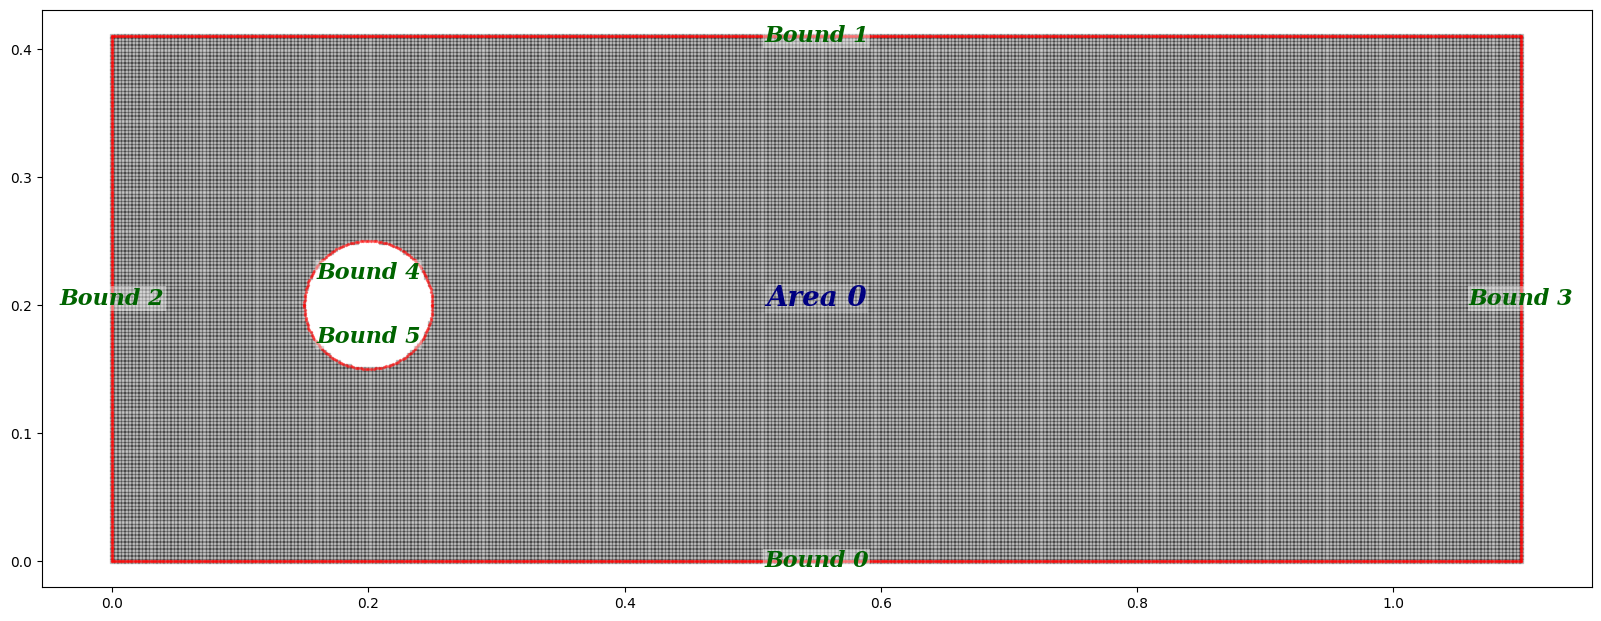

In [3]:
domain = ProblemDomain(rectangel.bound_list + circle.bound_list, [area])
domain.show_setup()

### 2. Define Physics

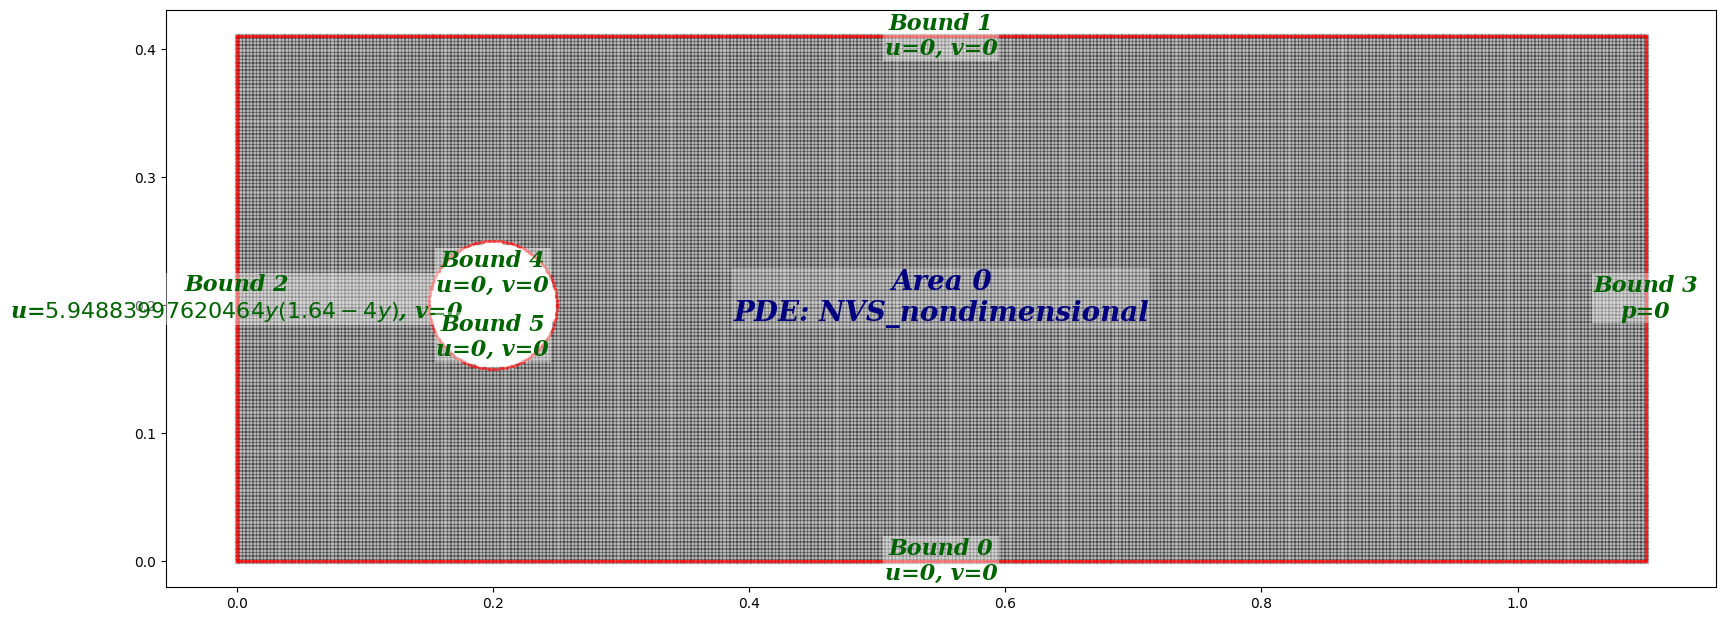

In [4]:
domain.bound_list[0].define_bc({'u':0,'v':0})
domain.bound_list[1].define_bc({'u':0,'v':0})
domain.bound_list[2].define_bc({'u': ['y', lambda x:  4*1*(0.41-x)*x/0.41**2], 'v': 0})
domain.bound_list[3].define_bc({'p':0})
domain.bound_list[4].define_bc({'u': 0, 'v': 0})
domain.bound_list[5].define_bc({'u': 0, 'v': 0})
domain.area_list[0].define_pde(Physics.NVS_nondimensional(U=0.0001, L=1, mu=0.001, rho=1000))
domain.show_setup()


Initial Sampling (mandatory if use RAR)

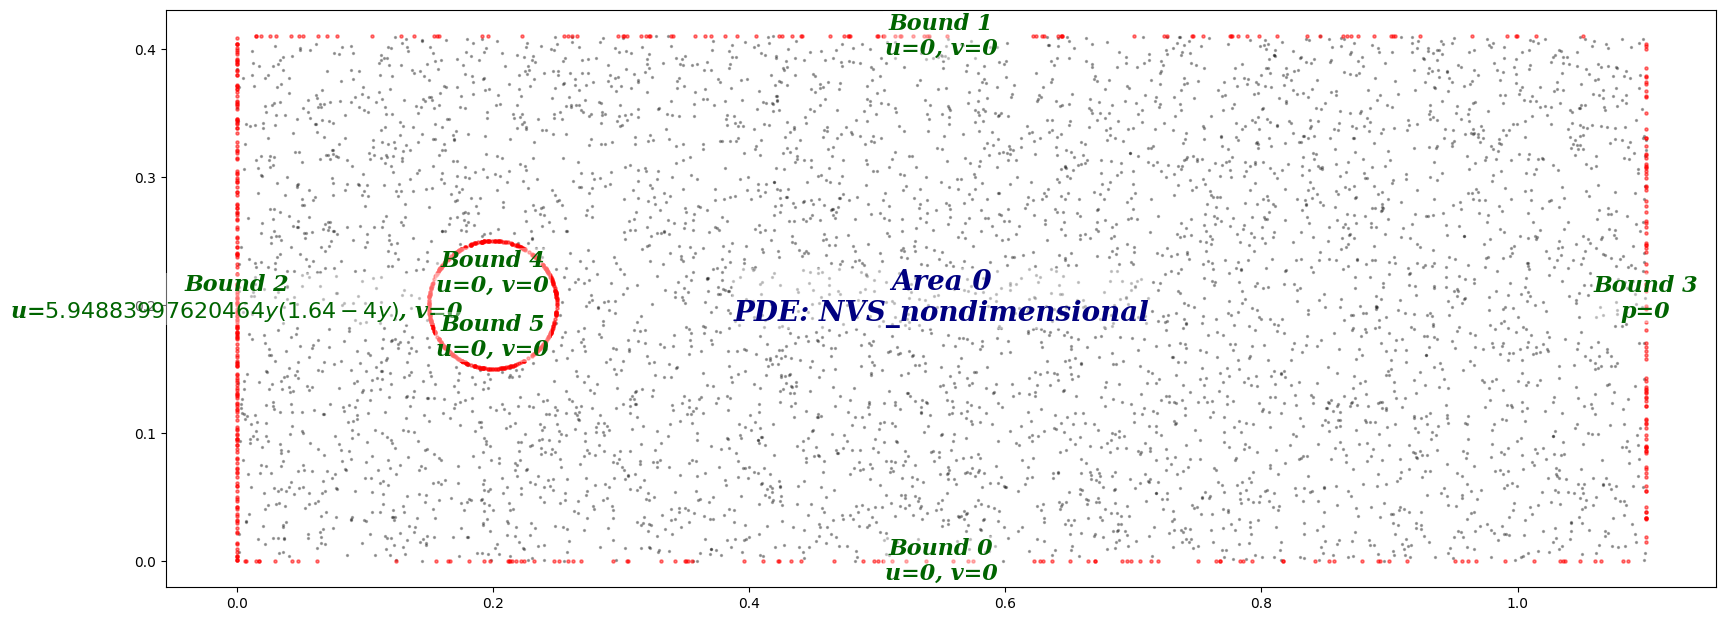

In [5]:
domain.sampling_random_r([100, 100, 200, 100, 200, 200], [5000], device='cuda')
domain.show_coordinates(display_conditions=True)

## 3. Training PINN

Create model

In [6]:
model0 = PINN(width=40, length=8)

Design the steps to train calculate Loss

In [7]:
# Define the loss calculation function
N = 0
def calc_loss(model):
    global N
    N += 1

    # Add collocation points using RAR scheme
    if N % 1000==0:
        domain.sampling_RAR([40, 40, 160, 40, 80, 80], [2000], model, [200, 200, 400, 200, 400, 400], [20000], device='cuda')
    
    # Resampling collocation points using Random-R scheme (less superior to RAR)
    # if N % 100 == 0:
    #     domain.sampling_random_r([100, 100, 200, 100, 200, 200], [5000], device='cuda')

    # BC Loss
    bc_loss = 0.0
    for i, bc in enumerate(domain.bound_list):
        if i == 2: # if inlet bound
            bc_loss += 2*bc.calc_loss(model)
        else:
            bc_loss += bc.calc_loss(model)

    # PDE Loss
    pde_loss = 0.0
    for i, area in enumerate(domain.area_list):
        pde_loss += area.calc_loss(model)

    # Total Loss
    total_loss = 3*bc_loss + pde_loss # weight bc_loss more

    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss} # MUST RETURN IN THIS FORMAT

Train the model using Adam optimizer

In [8]:
# Train the model
model1 = NetworkTrainer.train_adam(
    model=model0,
    calc_loss=calc_loss,
    learning_rate=0.0002,
    epochs=10000**0,
    print_every=250,
    thereshold_loss=0.03,
    device='cuda'
)

epoch 1, total_loss: 5.49468, bc_loss: 1.83155, pde_loss: 0.00003


Then, train the model using LBFGS optimizer

In [9]:
# Train the model
model2 = NetworkTrainer.train_lbfgs(
    model=model1,
    calc_loss=calc_loss,
    epochs=1000**0,
    print_every=50,
    thereshold_loss=0.001,
    device='cuda'
)

epoch 2, total_loss: 2.36792, bc_loss: 0.78905, pde_loss: 0.00078


Save or Load the model

In [10]:
import pickle
# Save model with pickle
with open("model2.pkl", "wb") as f:
    pickle.dump(model2, f)

# Load model back
with open("model2.pkl", "rb") as f:
    model2 = pickle.load(f)

Display final collocation points

In [11]:
domain.save_coordinates()
#domain.load_coordinates()

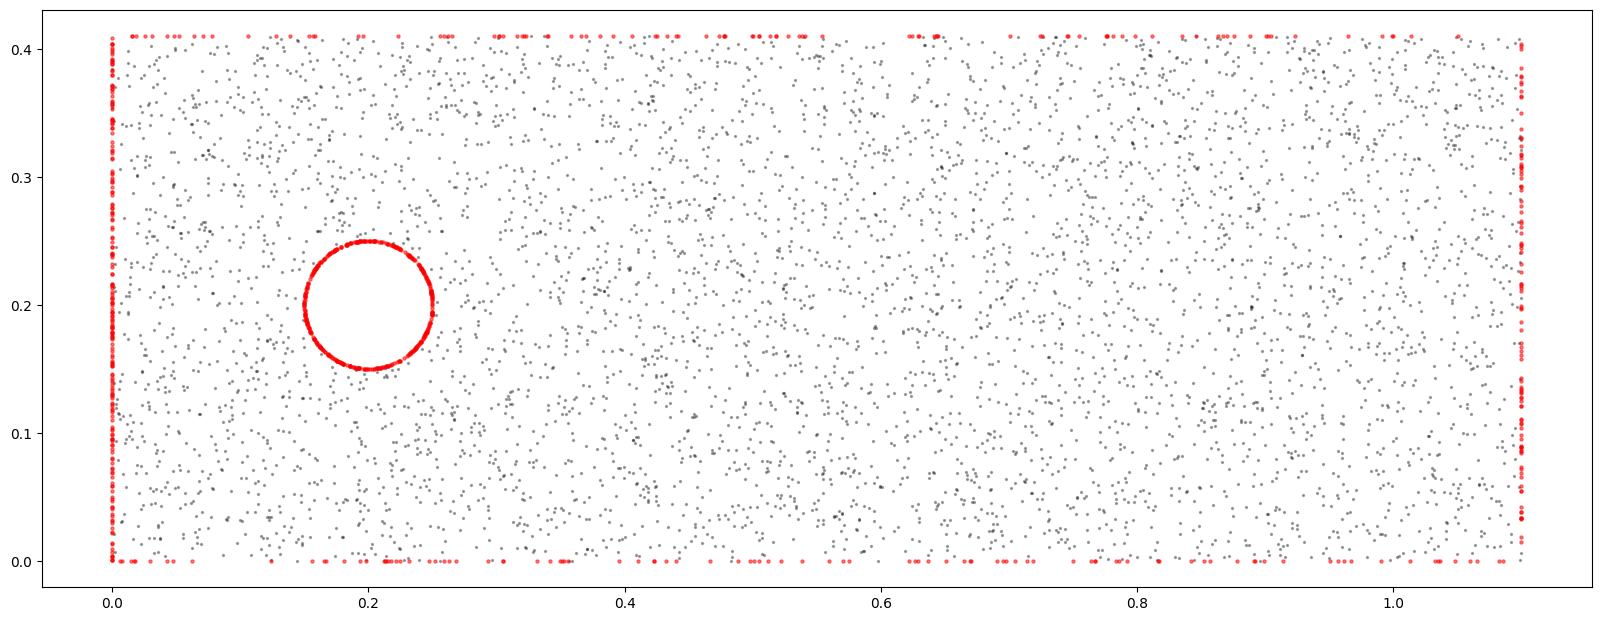

number of bound : 6
        ['0: 100', '1: 100', '2: 200', '3: 100', '4: 200', '5: 200']
        , number of area : 1
        ['0: 4921']


In [12]:
domain.show_coordinates()
print(domain)

## 4. Visualization

### 4.1 Visualize area

In [13]:
area_visual = Evaluate(model2, domain.area_list[0])
area_visual.sampling_area(500, 200)

available_data: ('u', 'v', 'p', 'velocity_magnitude', 'u_x', 'v_x', 'p_x', 'u_y', 'v_y', 'p_y', 'u_xx', 'v_xx', 'u_yy', 'v_yy', 'PDE residual', 'x', 'y', 'total_loss', 'bc_loss', 'pde_loss')


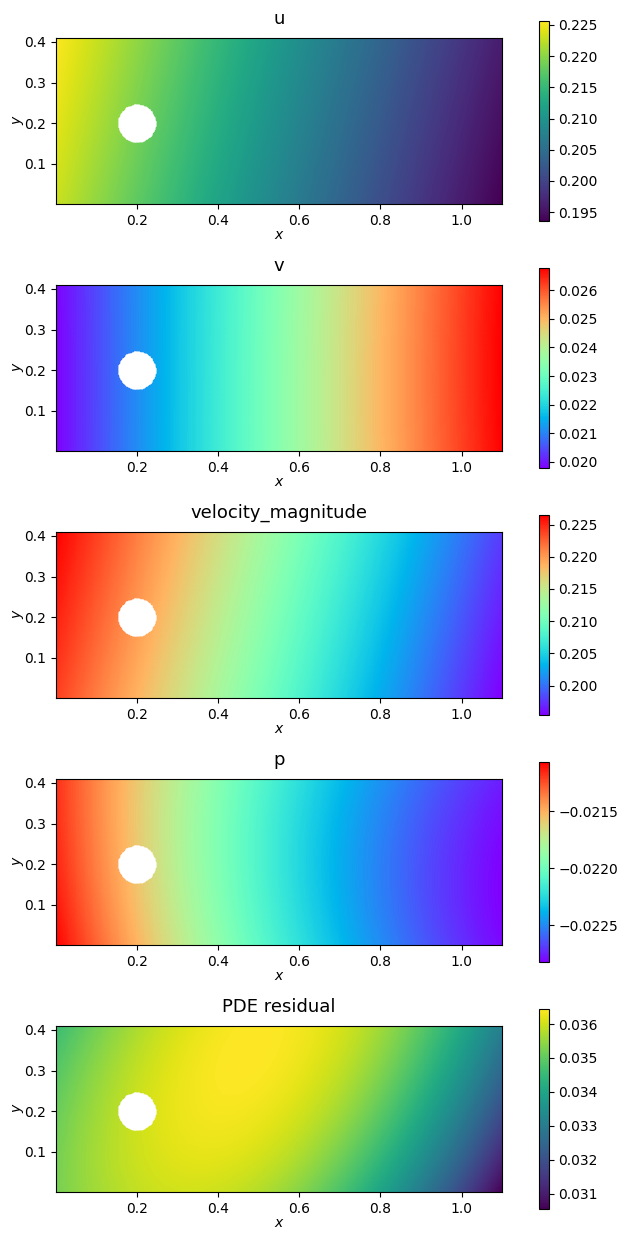

In [14]:
cmap_dict = {
    'u':None,
    'v':'rainbow',
    'velocity_magnitude': 'rainbow',
    'p':'rainbow',
    'PDE residual': None
}
colorplot_area_2d = area_visual.plot_data_on_geometry(cmap_dict, s=1)
colorplot_area_2d.savefig('colorplot_area_2d.png')

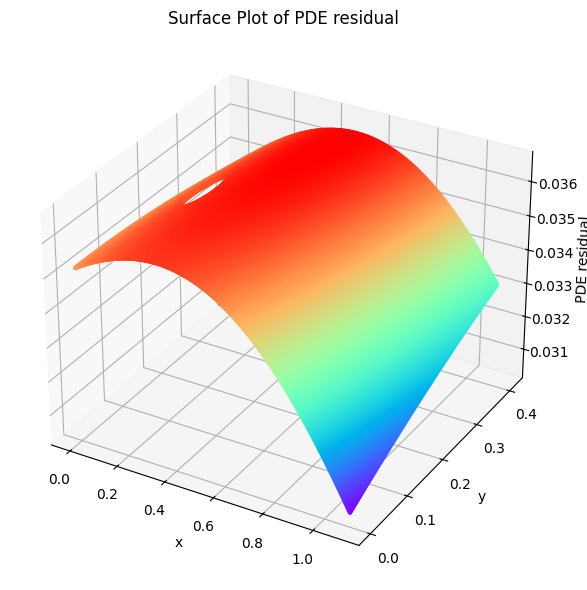

In [15]:
residual_plot_3d = area_visual.plot_data({'PDE residual':'rainbow'})
residual_plot_3d.savefig('residual_plot_3d.png')

### 4.2 Visualize bound

In [16]:
 # Create geometry object by Visualizer
bound_visual = Evaluate(model2, domain.bound_list[3])
bound_visual.sampling_line(100)

available_data: ('u', 'v', 'p', 'velocity_magnitude', 'BC residual', 'x', 'y', 'total_loss', 'bc_loss', 'pde_loss')


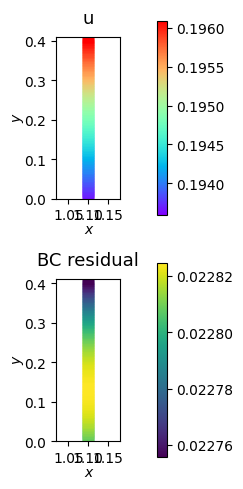

In [17]:
cmap_dict = {'u':'rainbow','BC residual':None}
colorplot_bound = bound_visual.plot_data_on_geometry(cmap_dict, s=50)
colorplot_bound.savefig('colorplot_bound.png')

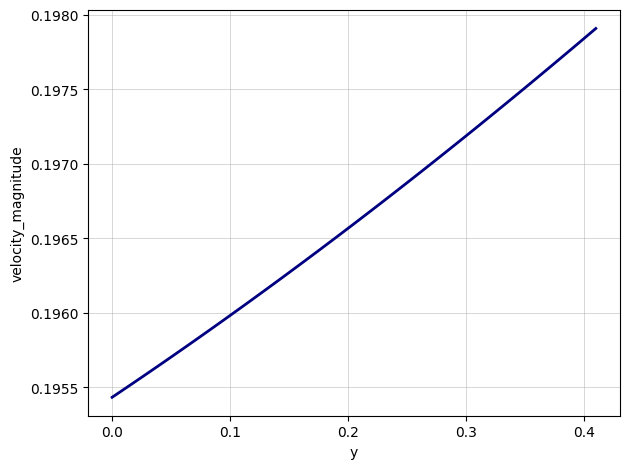

In [18]:
velocity_plot_outlet = bound_visual.plot_data({'velocity_magnitude':'viridis'}, axis='y')
velocity_plot_outlet.savefig('velocity_plot_outlet.png')

## 4.3 Visualize Neural Network data

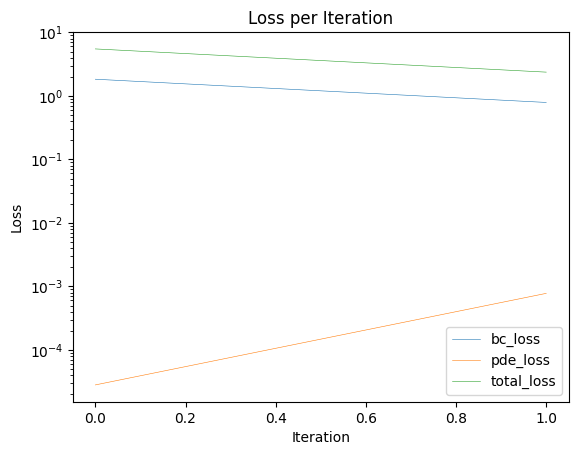

In [19]:
loss_history = bound_visual.plot_loss_curve(log_scale=True, linewidth=0.4)
loss_history.savefig('loss_history.png')

### 4.4 Export data

In [20]:
# display available options
print(bound_visual.data_dict.keys())

dict_keys(['u', 'v', 'p', 'velocity_magnitude', 'BC residual', 'x', 'y', 'total_loss', 'bc_loss', 'pde_loss'])


In [21]:
# store the x,y,velocity_magnitude data
x_data = bound_visual.data_dict['x']
y_data = bound_visual.data_dict['y']
velocity_magnitude_data = bound_visual.data_dict['velocity_magnitude']

#save as txt file
import numpy as np
array = np.column_stack((x_data, y_data, velocity_magnitude_data))
np.savetxt('outlet_velocity_profile.txt', array)